# Pre-process ESA Snow CCI data

- Snow Cover Fraction Climate Research Data Package: http://snow-cci.enveo.at/
- summer path: `/mnt/lalandmi/equipes/C2H/ESA_CCI_SNOW`

Check missing values, linear interpolation on time, and spatial aggregation

conda env: `phd_v3`

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)

import sys
sys.path.insert(1, 'utils') # to include my util file in previous directory
import utils as u # my personal functions
u.check_python_version()
# u.check_virtual_memory()

3.8.5 | packaged by conda-forge | (default, Jul 24 2020, 01:25:15) 
[GCC 7.5.0]


In [2]:
# For parallelisation
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')
client = Client(n_workers=8, threads_per_worker=1, memory_limit='6GB')
# client = Client()
client

Client Scheduler: tcp://127.0.0.1:36191 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 48.00 GB


In [11]:
client.close()

In [3]:
path_snow_CCI = 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg'
path_AVHRR = path_snow_CCI+'/AVHRR_MERGED/v2.0'
path_MODIS = path_snow_CCI+'/MODIS/v2.0'

path_out = 'ESA_CCI_SNOW/preprocess/scfg'
path_out_AVHRR = path_out+'/AVHRR_MERGED/v2.0'
path_out_MODIS = path_out+'/MODIS/v2.0'

In [ ]:
# for i in range(1982, 2019):
#     print(i)
#     !mkdir {path_out_AVHRR}'/daily/'{str(i)}

AVHRR Dimensions:
- lat: 3600
- lon: 7200

On GRICAD 32 cores (6 Go)

In [4]:
print(32/4); print(3600/4); print(7200/8)

8.0
900.0
900.0


## Define functions

In [4]:
import xarray as xr
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Get previous month for interpolation
def get_prev_month_year(month, year):
    '''
    Returns the previous month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '12')
            year_prev (string): string (e.g., '1999')
    '''
    if month == '01':
        year_prev = str(int(year) - 1)
        month_prev = '12'
    else:
        year_prev = year
        month_prev = str(int(month) - 1).zfill(2)
        
    return month_prev, year_prev

# Get next month for interpolation
def get_next_month_year(month, year):
    '''
    Returns the next month and corresponding year.

        Parameters:
            month (string): string of 2 characters (e.g., '01')
            year (string): string (e.g., '2000')

        Returns:
            month_prev (string): string of 2 characters (e.g., '02')
            year_prev (string): string (e.g., '2000')
    '''
    if month == '12':
        year_next = str(int(year) + 1)
        month_next = '01'
    else:
        year_next = year
        month_next = str(int(month) + 1).zfill(2)
        
    return month_next, year_next

# Round latitudes and longitudes to avoid errors with concatenation
def round_latlon(ds, latlon_round):
    '''
    Returns Dataset/DataArray with rounded latitudes and longitudes.

        Parameters:
            ds (Dataset/DataArray): xarray Dataset/Dataarray with coords lat/lon
            latlon_round (int): number of decimals

        Returns:
            xarray Dataset/DataArray
    '''
    return ds.assign_coords(lat=ds.lat.round(latlon_round), lon=ds.lon.round(latlon_round))

# Reindex time to get all days for interpolation
def reindex_time(ds, year, month):
    '''
    Returns Dataset/DataArray with all days in the corresponding month. Missing days will be filled with NaNs.

        Parameters:
            ds (Dataset/DataArray): monthly xarray Dataset/DataArray at daily time frequency
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')

        Returns:
            xarray Dataset/DataArray
    '''
    begin_date = pd.to_datetime(year+'-'+month+'-01')
    end_date = begin_date + MonthEnd(1) # Get the last day of the month
    return ds.reindex(time=pd.date_range(begin_date, end_date, freq='D'))

# Reindex time to get all days for interpolation
def open_files(path, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var):
    '''
    Open all daily files for a given month in parallel.
    Format is e.g., path+'/1994/01/19940101'+common_file_string
        
        Need to have Dask client defined before, e.g.:
            from dask.distributed import Client
            client = Client(n_workers=32, threads_per_worker=1, memory_limit='6GB')

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
            common_file_string (string): e.g., '-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc'
            chunk_lat (int): chunk over the latitude dimension
            chunk_lon (int): chunk over the longitude dimension
            latlon_round (int): number of decimals
            var (string): variable to open (e.g., 'scfg')

        Returns:
            da (DataArray): xarray DataArray
            attrs (dict): attributes from the original dataset
    '''
    ds = xr.open_mfdataset(path+'/'+year+'/'+month+'/*'+common_file_string, 
                           parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
    da = ds[var]
    da = round_latlon(da, latlon_round) # round coordinates to avoid errors with concatenation
    da = reindex_time(da, year, month) # to fill missing days with NaNs
    print('Read files '+path+'/'+year+'/'+month+'/*'+common_file_string)
            
    return da, ds.attrs

# Print no file to open
def print_no_file(path, year, month):
    '''
    Print the folder where there is no file.

        Parameters:
            path (string): root path (e.g., 'ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0')
            year (string): string (e.g., '2000')
            month (string): string of 2 characters (e.g., '01')
    '''
    print('No file to open in: '+path+'/'+year+'/'+month)

# Select last delta_interp days for previous period
def select_last_days(da_prev, year_prev, month_prev, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_prev (DataArray): monthly xarray DataArray at daily time frequency
            year_prev (string): string (e.g., '2000')
            month_prev (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    end_date = pd.to_datetime(year_prev+'-'+month_prev) + MonthEnd(1) # Get the last day of the month
    begin_date = end_date - pd.DateOffset(days = delta_interp) # Get previous delta_interp days (max window for interpolation)
    return da_prev.sel(time=slice(begin_date, end_date))

# Select next delta_interp days for next period
def select_first_days(da_next, year_next, month_next, delta_interp):
    '''
    Returns Dataset with the last delta_interp days.

        Parameters:
            da_next (DataArray): monthly xarray DataArray at daily time frequency
            year_next (string): string (e.g., '2000')
            month_next (string): string of 2 characters (e.g., '01')
            delta_interp (int): maximum gap number of days for interpolation

        Returns:
            xarray DataArray
    '''
    return da_next.sel(time=slice(year_next+'-'+month_next+'-01', year_next+'-'+month_next+'-'+str(delta_interp).zfill(2)))
     
# Concatenate DataArrays over time
def concat_files(da1, da2, concat_string):
    '''
    Concatenate DataArrays and remove chunks over the time dimension.

        Parameters:
            da1, da2 (DataArray): monthly xarray DataArray at daily time frequency
            concat_string (string): description of concatenation (e.g., '[prev, current]')

        Returns:
            xarray DataArray
    '''
    concat = xr.concat([da1, da2], dim='time').chunk({'time': -1})
    print(' => Concatenate files '+concat_string)
    
    return concat  


## Run interpolation

In [5]:
%%time

import time

chunk_lat = 900
chunk_lon = 900
delta_interp = 10 # maximum gap number of days for interpolation
latlon_round = 3 # precision for lat/lon
common_file_string = '-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc'
var = 'scfg'

# for year in [str(y) for y in range(1982, 2019)]:
# for year in [str(y) for y in range(1982, 2010)]:
for year in [str(y) for y in range(2010, 2019)]:
    for month in [str(m).zfill(2) for m in range(1, 13)]:
#     for month in [str(m).zfill(2) for m in range(6, 9)]:
        start_time = time.time() # Check time per loop
        
        # Get previous and next months for interpolation         
        month_prev, year_prev = get_prev_month_year(month, year)
        month_next, year_next = get_next_month_year(month, year)
        print('\n### '+year+'-'+month+' (prev: '+year_prev+'-'+month_prev+' / next: '+year_next+'-'+month_next+')')
        
        ##################
        ### Open files ###
        ##################
        # Test if there are files (ex: 1994-11 to 1995-01 no files for AVHRR)
        try:
            da, attrs = open_files(path_AVHRR, year, month, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
        except OSError:
            print_no_file(path_AVHRR, year, month)
            continue # If there is no file, go to next iteration
        
        # Prev
        try:
            da_prev, _ = open_files(path_AVHRR, year_prev, month_prev, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
            da_prev = select_last_days(da_prev, year_prev, month_prev, delta_interp)
            concat = concat_files(da_prev, da, '[prev, current]')
            
            # Next
            try:
                da_next, _ = open_files(path_AVHRR, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(concat, da_next, '[concat, next]')
            except OSError:
                print_no_file(path_AVHRR, year_next, month_next)

        except OSError:
            print_no_file(path_AVHRR, year_prev, month_prev)
        
            # Next
            try:
                da_next, _ = open_files(path_AVHRR, year_next, month_next, common_file_string, chunk_lat, chunk_lon, latlon_round, var)
                da_next = select_first_days(da_next, year_next, month_next, delta_interp)
                concat = concat_files(da, da_next, '[current, next]')
            except OSError:
                print_no_file(path_AVHRR, year_next, month_next)
                concat = da.chunk({'time': -1})

        ###############################################
        ### Get SCF values and, water and ice masks ###
        ###############################################
        scf = concat.where(concat <= 100)
        water = concat.where(concat == 210)
        ice = concat.where(concat == 215)
        
        ###############################
        ### Linear temporal gapfill ###
        ###############################
        scf_interp = scf.interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=delta_interp))
        print(' => Doing interpolation...')

        # Deal with attributes
        scf_interp.name = var+'_interp'
        del scf_interp.attrs['valid_range']
        del scf_interp.attrs['flag_values']
        del scf_interp.attrs['flag_meanings']
        scf_interp.attrs['ancillary_variables'] = 'coverage, coverage_interp'
        scf_interp.attrs['method'] = var+".interpolate_na('time', method='linear', max_gap=pd.Timedelta(days=10))"

        # Compute time coverage
        coverage = scf.sel(time=year+'-'+month).count('time')
        coverage.name = 'coverage'
        coverage.attrs['long_name'] = 'Time Coverage'
        coverage.attrs['units'] = 'number of days'
        coverage.attrs['ancillary_variables'] = var

        coverage_interp = scf_interp.sel(time=year+'-'+month).count('time')
        coverage_interp.name = 'coverage_interp'
        coverage_interp.attrs['long_name'] = 'Time Coverage'
        coverage_interp.attrs['units'] = 'number of days'
        coverage_interp.attrs['ancillary_variables'] = var+'_interp'

        ice.name = 'mask_ice'
        ice.attrs['long_name'] = 'Permanent_Snow_and_Ice'
        del ice.attrs['units']
        del ice.attrs['standard_name']
        del ice.attrs['valid_range']
        del ice.attrs['actual_range']
        ice.attrs['flag_value'] = 215
        del ice.attrs['flag_values']
        del ice.attrs['flag_meanings']
        del ice.attrs['grid_mapping']
        del ice.attrs['ancillary_variables']

        water.name = 'mask_water'
        water.attrs['long_name'] = 'Water'
        del water.attrs['units']
        del water.attrs['standard_name']
        del water.attrs['valid_range']
        del water.attrs['actual_range']
        water.attrs['flag_value'] = 210
        del water.attrs['flag_values']
        del water.attrs['flag_meanings']
        del water.attrs['grid_mapping']
        del water.attrs['ancillary_variables']

        # Combine in a new dataset
        ds_interp = scf_interp.sel(time=year+'-'+month).to_dataset()
        ds_interp['coverage'] = coverage
        ds_interp['coverage_interp'] = coverage_interp
        ds_interp['mask_ice'] = ice[0]
        ds_interp['mask_water'] = water[0]
        ds_interp.attrs = {**{'processed': 'A linear interpolation on the time dimension is performed in this dataset. ' \
            'A maximum window of 10 days is imposed, if the gap is more than 10 days, the missing values are kept. ' \
            'Before interpolation the time dimension is reindexed in order to cover all days of the month, and fill missing days with NaNs.' \
            'Also the latitudes and longitudes are rounded to 3 digits after de decimal to avoid concatenation errors.' \
            'The temporal coverage of the data before and after interpolation is stored in the variables "coverage" and "coverage_interp". ' \
            'The permanent snow and ice, and water masks are also kept for later processing if needed. The original dataset is described below. ' \
            'Preprocess performed by Mickaël Lalande (https://mickaellalande.github.io/) on May 13, 2022. ' \
            'The same compression level is kept compared to the original dataset (zlib=True, complevel=4).'}, **attrs}

        # Compression
        comp = dict(zlib=True, complevel=4)
        encoding = {var: comp for var in ds_interp.data_vars}
        ds_interp.to_netcdf(path_out_AVHRR+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc', encoding=encoding)
        print('Interpolated file saved to '+path_out_AVHRR+'/daily/'+year+'/'+year+month+'-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
        print("--- %s seconds ---" % (time.time() - start_time))


### 2010-01 (prev: 2009-12 / next: 2010-02)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2010/01/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2009/12/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [prev, current]
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2010/02/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
 => Concatenate files [concat, next]
 => Doing interpolation...
Interpolated file saved to ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2010/201001-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 112.75979995727539 seconds ---

### 2010-02 (prev: 2010-01 / next: 2010-03)
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED/v2.0/2010/02/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0.nc
Read files ESA_CCI_SNOW/dap.ceda.ac.uk/neodc/esacci/snow/data/scfg/AVHRR_MERGED

## Check
Be aware that without rounding lat/lon there troubles for  2010-06 to 08 and 2017 same mnths

In [18]:
scf.sel(lat=50, lon=110, method='nearest').values

array([ nan,  nan,  32.,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan, 100.,  nan,  nan,  nan,  nan,  nan,  84.,  nan,
        nan, 100.,  nan,  nan,  nan,  nan,  nan,  58.,  nan,  nan,  56.,
        nan,  nan,  nan,  nan,  81.,  nan,  nan,  nan,  nan],
      dtype=float32)

In [23]:
ds_interp.scfg_interp.sel(lat=50, lon=110, method='nearest').values

array([       nan,        nan,        nan, 100.      ,  97.333336,
        94.666664,  92.      ,  89.333336,  86.666664,  84.      ,
        89.333336,  94.666664, 100.      ,  93.      ,  86.      ,
        79.      ,  72.      ,  65.      ,  58.      ,  57.333332,
        56.666668,  56.      ,  61.      ,  66.      ,  71.      ,
        76.      ,  81.      ,        nan,        nan,        nan,
              nan], dtype=float32)

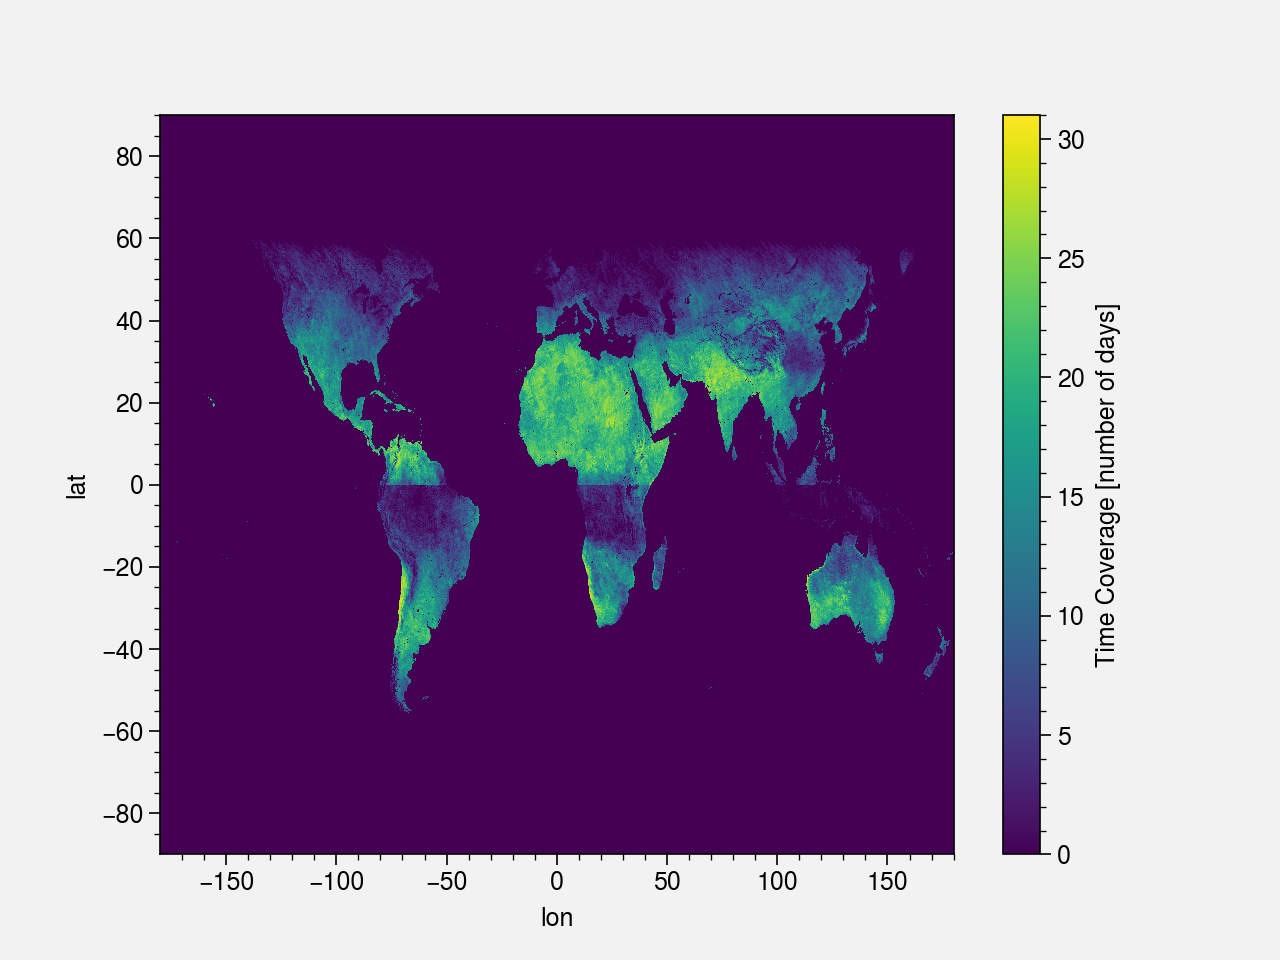

In [21]:
ds_interp.coverage.plot(vmax=31)

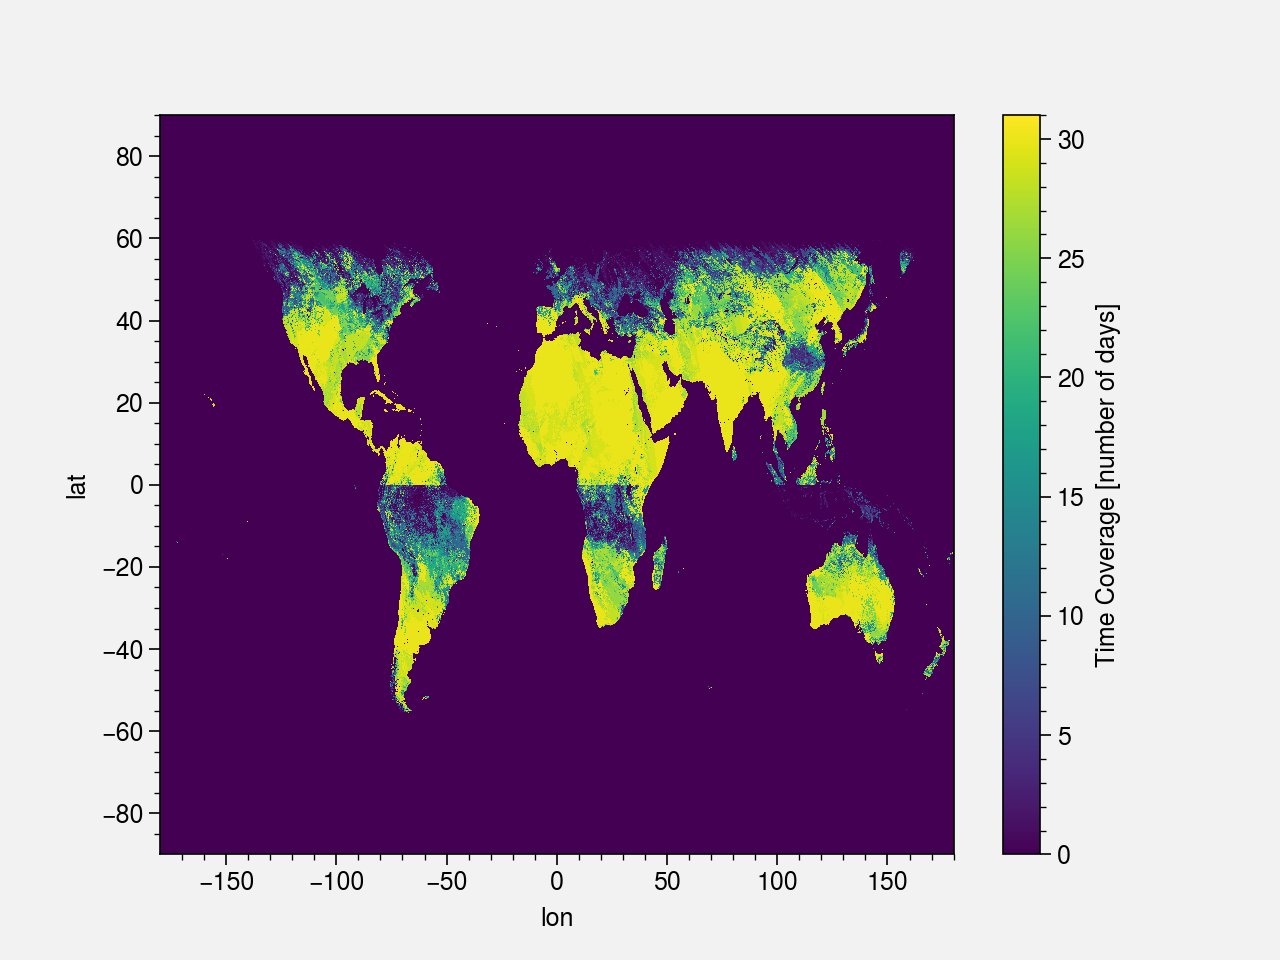

In [22]:
ds_interp.coverage_interp.plot(vmax=31)

There is always a gap at the equator... different satellite or other?

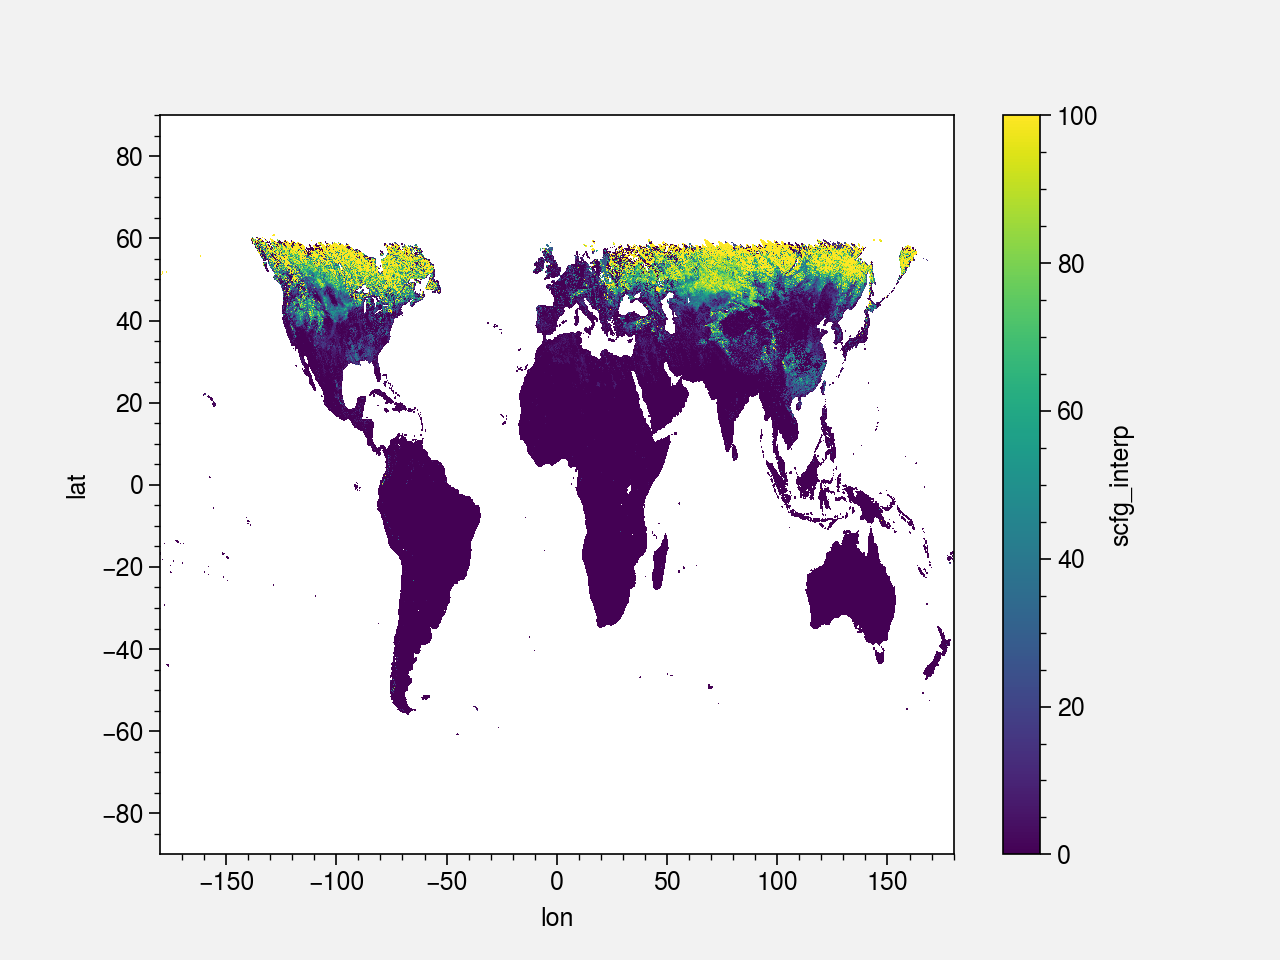

In [24]:
ds_interp.scfg_interp.mean('time').plot()

# Make monthly mean

In [3]:
root_path_in = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily'
root_path_out = '/bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly'

AVHRR Dimensions:
- lat: 3600
- lon: 7200

On GRICAD 32 cores (6 Go)

In [9]:
print(32/4); print(3600/4); print(7200/8)

8.0
900.0
900.0


In [4]:
%%time

import time

# Increase a bit the chunks as I leave the chunk on time (monthly chunk 31 days)
chunk_lat = 1800 #900
chunk_lon = 1800 #900

# for year in [str(y) for y in range(1982, 2019)]:
for year in [str(y) for y in range(1988, 2019)]:
    start_time = time.time() # Check time per loop
    
    print('\n### '+year)
    
    ds = xr.open_mfdataset(root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc', parallel=True, chunks={'lat': chunk_lat, 'lon': chunk_lon})
#     ds = xr.open_mfdataset(root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc', parallel=True)
    print('Read files '+root_path_in+'/'+year+'/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
    
#     ds_month = ds.chunk({'time': -1}).resample(time='1M').mean() # too heavy
    ds_month = ds.resample(time='1M').mean()
    print(' => Perform monthly resample average...')
    
    ds_month.attrs = ds.attrs
    
     # Compression
    comp = dict(zlib=True, complevel=4)
    encoding = {var: comp for var in ds_month.data_vars}
    ds_month.to_netcdf(root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc', encoding=encoding)
    print('Monthly file saved to '+root_path_out+'/'+year+'-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc')
    print("--- %s seconds ---" % (time.time() - start_time))


### 1988
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1988/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1988-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.86386156082153 seconds ---

### 1989
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1989/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1989-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 212.4295003414154 seconds ---

### 1990
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1990/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1990-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 212.43603110313416 seconds ---

### 1991
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1991/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1991-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 213.6138138771057 seconds ---

### 1992
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1992/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1992-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 217.42414712905884 seconds ---

### 1993
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1993/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1993-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 218.8436369895935 seconds ---

### 1994


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1994/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1994-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 177.56237697601318 seconds ---

### 1995
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1995/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1995-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 198.0853316783905 seconds ---

### 1996
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1996/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1996-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.3510286808014 seconds ---

### 1997
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1997/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1997-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 218.45961809158325 seconds ---

### 1998


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1998/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1998-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 217.2022316455841 seconds ---

### 1999
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/1999/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/1999-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.82799339294434 seconds ---

### 2000
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2000/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2000-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 215.55658054351807 seconds ---

### 2001
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2001/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2001-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.2906174659729 seconds ---

### 2002
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2002/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2002-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 218.7656764984131 seconds ---

### 2003


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2003/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...
Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2003-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 218.0941081047058 seconds ---

### 2004
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2004/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2004-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 216.52267050743103 seconds ---

### 2005
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2005/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2005-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 222.03664374351501 seconds ---

### 2006
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2006/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2006-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 213.19689917564392 seconds ---

### 2007
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2007/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2007-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 222.64381384849548 seconds ---

### 2008
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2008/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2008-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.42620587348938 seconds ---

### 2009
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2009/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2009-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.92460083961487 seconds ---

### 2010
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2010/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2010-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 221.86381769180298 seconds ---

### 2011
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2011/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2011-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 217.97070360183716 seconds ---

### 2012
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2012/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2012-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 215.64070796966553 seconds ---

### 2013
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2013/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2013-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 213.23284220695496 seconds ---

### 2014
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2014/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2014-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 224.88888597488403 seconds ---

### 2015
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2015/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2015-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 215.72939610481262 seconds ---

### 2016
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2016/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2016-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 215.2160632610321 seconds ---

### 2017
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2017/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2017-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 213.41566395759583 seconds ---

### 2018
Read files /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/daily/2018/*-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
 => Perform monthly resample average...


/bettik/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/common.py:1123: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  grouper = pd.Grouper(


Monthly file saved to /bettik/lalandmi/phd/ESA_CCI_SNOW/preprocess/scfg/AVHRR_MERGED/v2.0/monthly/2018-monthly-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv2.0_interp.nc
--- 214.69917345046997 seconds ---
CPU times: user 10min 1s, sys: 1min 8s, total: 11min 9s
Wall time: 1h 50min 53s


In [7]:
ds = xr.open_mfdataset(root_path_out+'/*.nc', parallel=True)
ds

,Array,Chunk
Bytes,91.45 GB,2.49 GB
Shape,"(441, 3600, 7200)","(12, 3600, 7200)"
Count,111 Tasks,37 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,91.45 GB,2.49 GB
Shape,"(441, 3600, 7200)","(12, 3600, 7200)"
Count,111 Tasks,37 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


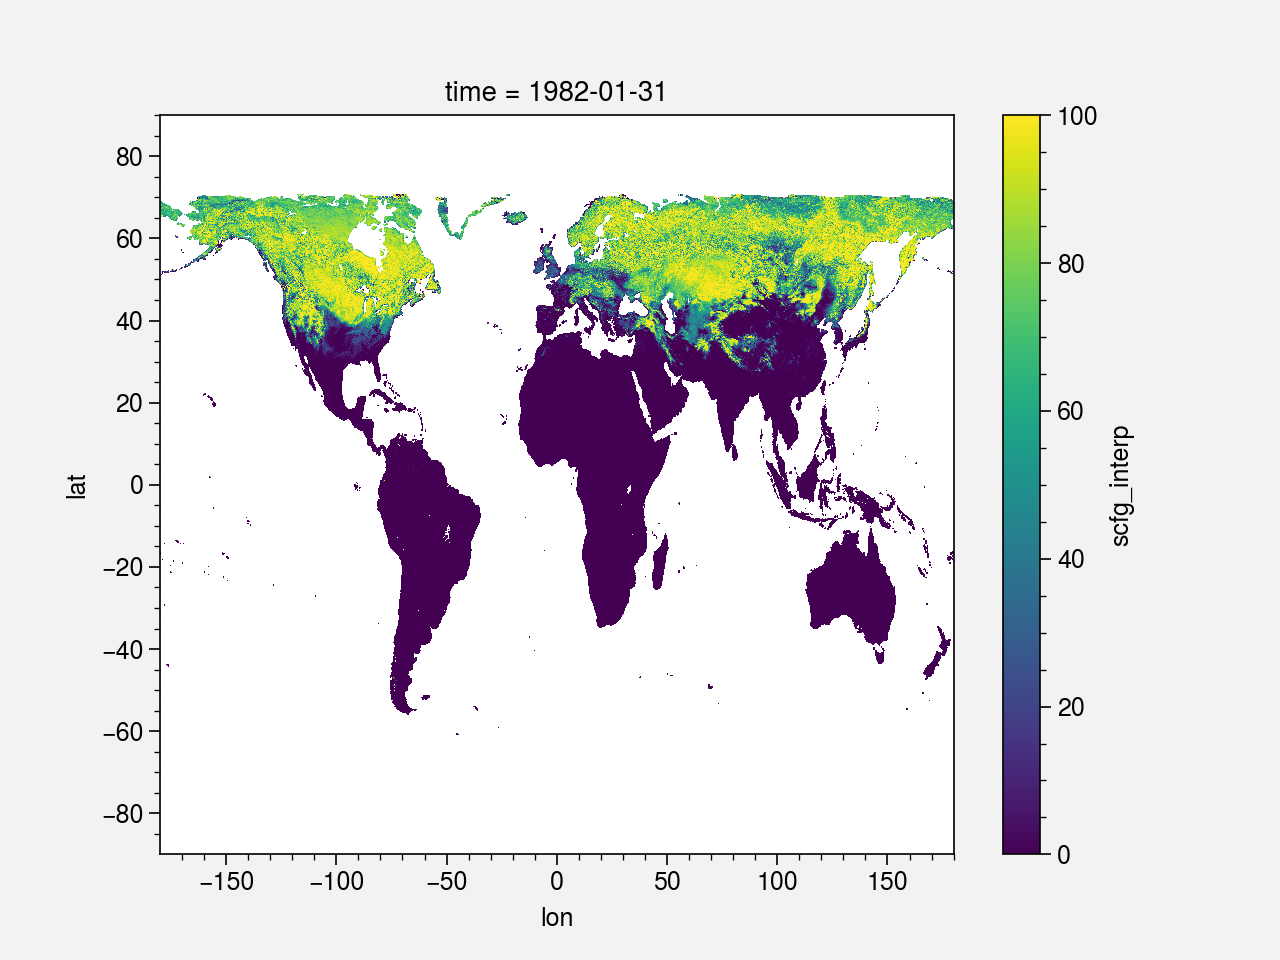

In [10]:
ds.scfg_interp[0].plot()

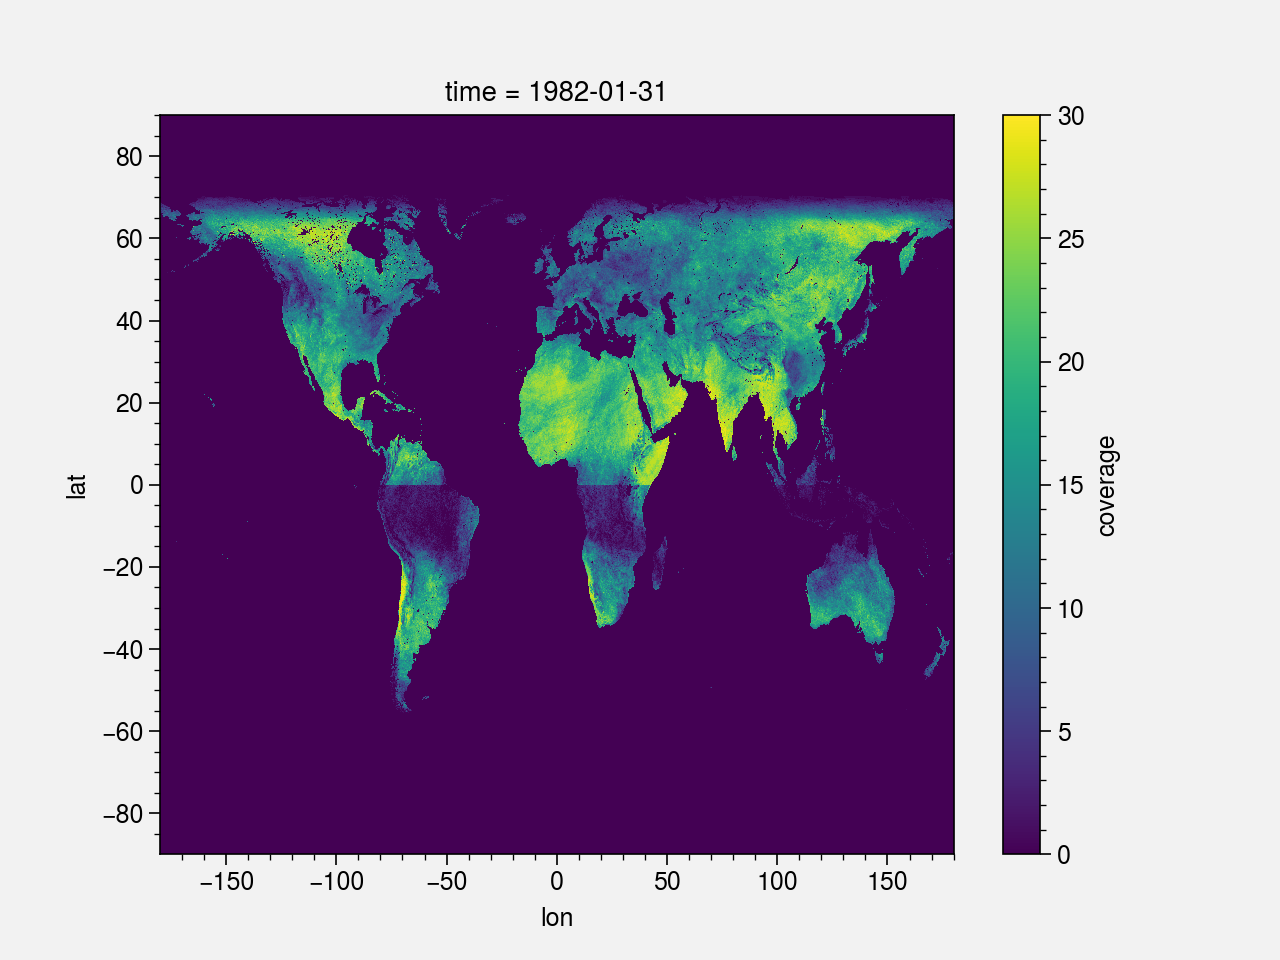

In [11]:
ds.coverage[0].plot()

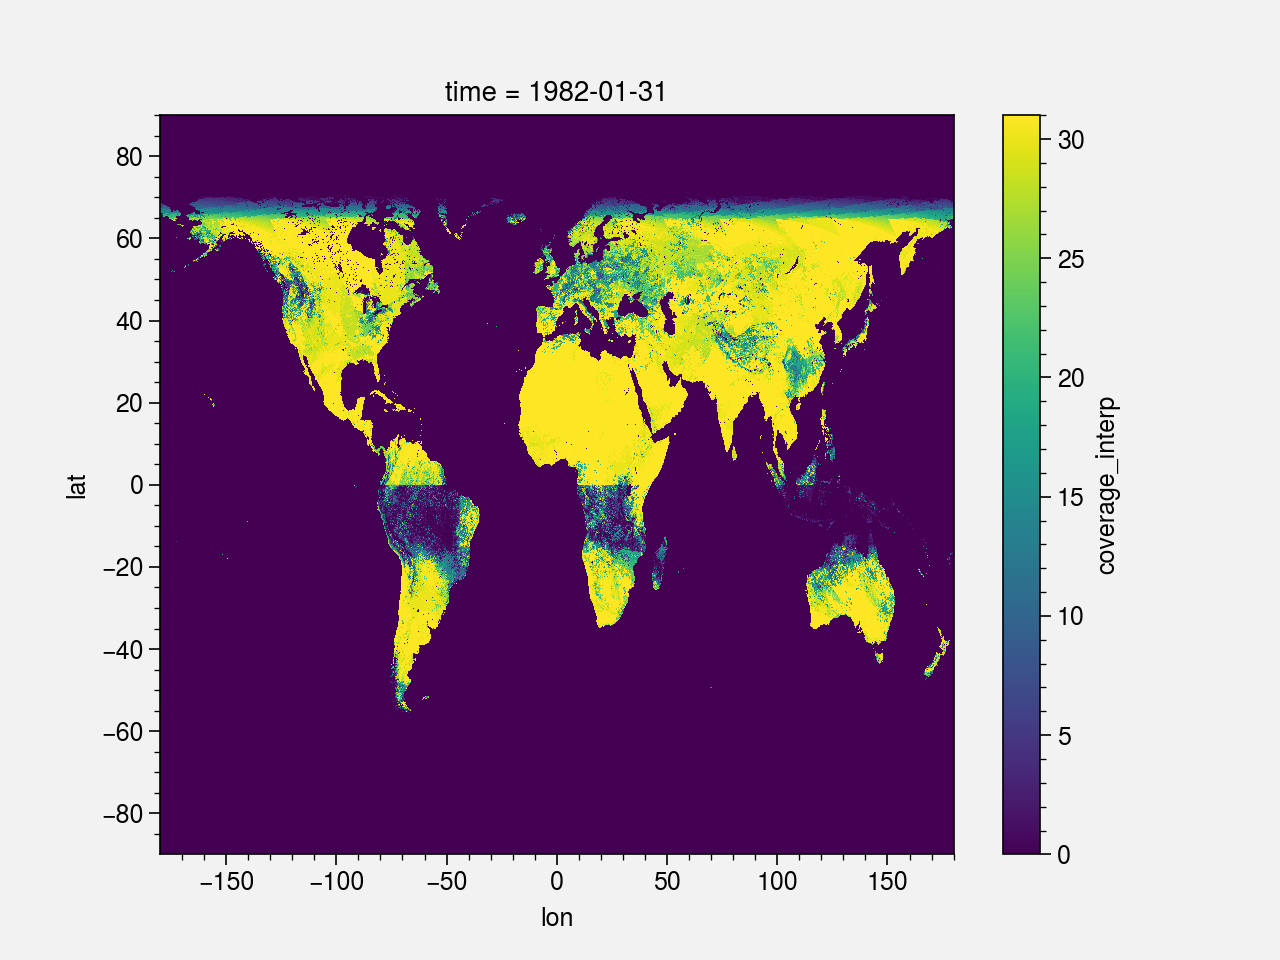

In [12]:
ds.coverage_interp[0].plot()

# Make spatial average